Original code taken from [https://gist.github.com/EderSantana/c7222daa328f0e885093](https://gist.github.com/EderSantana/c7222daa328f0e885093)

## Instructions
0. If you haven't already, follow [the setup instructions here](https://jennselby.github.io/MachineLearningCourseNotes/#setting-up-python3) to get all necessary software installed.
0. To be able to run the animation below, make sure you have the latest version of matplotlib, by running `python3 -m pip install matplotlib --upgrade`
0. Read through the code in the following sections:
    * [Define game environment and replay classes](#Define-game-environment-and-replay-classes)
    * [Define functions to create model, train, and visualize](#Define-functions-to-create-model,-train,-and-visualize)
    * [Try untrained model](#Try-untrained-model)
    * [Train and assess model](#Train-and-assess-model)
0. Complete some of the [Possible Exercises](#Possible-Exercises)

In [1]:
%matplotlib inline
import json
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Reshape
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import matplotlib.animation
import IPython.display


## Define game environment and replay classes
The idea in this FallingFruit game is that the user has to move to try to dodge the fruit. If they dodge it, they win and the game is over. If they get hit by it, they lose and the game is over. We are trying to teach the computer to play this game.

In [2]:
class FallingFruit(object):
    def __init__(self, grid_size=10):
        '''
        Input: grid_size (length of the side of the canvas)
        
        Initializes internal state.
        '''
        self.grid_size = grid_size
        self.min_player_center = 1
        self.max_player_center = self.grid_size-2
        self.reset()

    def _update_state(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Moves player according to action. Moves fruit down. Updates state to reflect these movements
        '''
        if action == 0:  # left
            movement = -1
        elif action == 1:  # stay
            movement = 0
        elif action == 2: # right
            movement = 1
        else:
            raise Exception('Invalid action {}'.format(action))
        fruit_x, fruit_y, player_center = self.state
        # move the player unless this would move it off the edge of the grid
        new_player_center = min(max(self.min_player_center, player_center + movement), self.max_player_center)
        # move fruit down
        fruit_y += 1
        out = np.asarray([fruit_x, fruit_y, new_player_center])
        self.state = out

    def _draw_state(self):
        '''
        Returns a 2D numpy array with 1s (white squares) at the locations of the fruit and player and
        0s (black squares) everywhere else.
        '''
        im_size = (self.grid_size, self.grid_size)
        canvas = np.zeros(im_size)
        
        fruit_x, fruit_y, player_center = self.state
        canvas[fruit_y, fruit_x] = 1  # draw fruit
        canvas[-1, player_center-1:player_center + 2] = 1  # draw 3-pixel player
        return canvas

    def _get_reward(self):
        '''
        Returns 1 if the fruit was dodged, -1 if it hit, and 0 if it is still in the air.
        '''
        fruit_x, fruit_y, player_center = self.state
        if fruit_y == self.grid_size-1:
            if abs(fruit_x - player_center) <= 1:
                return -1 # it was hit and that's no good :D
            else:
                return 1 # trains to dodge fruit
            
            # if we were to change it to 1 and -1 respectively, then it would reverse the goal of the game to 
            # catch the fruit and try to not dodge the fruit #
            
            # but since i need to compare the outputs of the CNN vs. the feed forward NN, i left it as it was originally
            
        else:
            return 0 # the fruit is still in the air

    def observe(self):
        '''
        Returns the current canvas, as a 1D array.
        '''
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        '''
        Input: action (0 for left, 1 for stay, 2 for right)
        
        Returns:
            current canvas (as a 1D array)
            reward received after this action
            True if episode is over and False otherwise
        '''
        self._update_state(action)
        observation = self.observe()
        reward = self._get_reward()
        episode_over = (reward != 0) # if the reward is zero, the fruit is still in the air
        return observation, reward, episode_over

    def reset(self):
        '''
        Updates internal state
            fruit in a random column in the top row
            player center in a random column
        '''
        fruit_x = random.randint(0, self.grid_size-1)
        fruit_y = 0
        player_center = random.randint(self.min_player_center, self.max_player_center)
        self.state = np.asarray([fruit_x, fruit_y, player_center])


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, episode_over):
        '''
        Input:
            states: [starting_observation, action_taken, reward_received, new_observation]
            episode_over: boolean
        Add the states and episode over to the internal memory array. If the array is longer than
        self.max_memory, drop the oldest memory
        '''
        self.memory.append([states, episode_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        '''
        Randomly chooses batch_size memories, possibly repeating.
        For each of these memories, updates the models current best guesses about the value of taking a
            certain action from the starting state, based on the reward received and the model's current
            estimate of how valuable the new state is.
        '''
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1] # the number of possible actions
        env_dim = self.memory[0][0][0].shape[1] # the number of pixels in the image
        input_size = min(len_memory, batch_size)
        inputs = np.zeros((input_size, env_dim))
        targets = np.zeros((input_size, num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory, size=input_size)):
            starting_observation, action_taken, reward_received, new_observation = self.memory[idx][0]
            episode_over = self.memory[idx][1]

            # Set the input to the state that was observed in the game before an action was taken
            inputs[i] = starting_observation[0]
            
            # Start with the model's current best guesses about the value of taking each action from this state
            targets[i] = model.predict(starting_observation)[0]
            
            # Now we need to update the value of the action that was taken                      
            if episode_over: 
                # if the episode is over, give the actual reward received
                targets[i, action_taken] = reward_received
            else:
                # if the episode is not over, give the reward received (always zero in this particular game)
                # plus the maximum reward predicted for state we got to by taking this action (with a discount)
                Q_sa = np.max(model.predict(new_observation)[0])
                targets[i, action_taken] = reward_received + self.discount * Q_sa
        return inputs, targets




##  Define functions to create model, train, and visualize

In [3]:
# parameters
epsilon = .1  # probability of exploration (choosing a random action instead of the current best one)
num_actions = 3  # [move_left, stay, move_right]
max_memory = 500
hidden_size = 100
batch_size = 50
grid_size = 10
print_freq = 10


def build_model():
    '''
     Returns three initialized objects: the model, the environment, and the replay.
    '''
    model = Sequential()
    # model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu')) # DENSE = FEED FORWARD NN 
    # model.add(Dense(hidden_size, activation='relu'))
    # model.add(Dense(num_actions))
    model.add(Reshape((grid_size,grid_size,1), input_shape=(grid_size**2,))) # reshape to be 10x10
    model.add(Conv2D(4, (3,3))) # f filters (first layer of the two) 
    model.add(Conv2D(5, (3,3))) # g filters (second layer of two)
    model.add(Flatten()) # take f and g layers and flatten them into a 9x9x5 to be then fed into a simple NN
    model.add(Dense(64)) # 64 neurons for the simple NN
    model.add(Dense(num_actions, activation="softmax")) # one neuron per action, softmax gives us a probability for L R or S#
    
    model.compile(Adam(), "mse")

    # Define environment/game
    env = FallingFruit(grid_size)

    # Initialize experience replay object
    exp_replay = ExperienceReplay(max_memory=max_memory)
    
    return model, env, exp_replay

def take_step(exp_replay, model, starting_observation):
    # get next action
    if np.random.rand() <= epsilon:
        # epsilon of the time, we just choose randomly
        action = np.random.randint(0, num_actions, size=1)
    else:
        # find which action the model currently thinks is best from this state
        q = model.predict([starting_observation])
        action = np.argmax(q[0])

    # apply action, get rewards and new state
    new_observation, reward, episode_over = env.act(action)

    # store experience
    exp_replay.remember([starting_observation, action, reward, new_observation], episode_over)

    return new_observation, reward, episode_over
    

def train_model(model, env, exp_replay, num_episodes, pretrain_episodes=100):
    '''
    Inputs:
        model, env, and exp_replay objects as returned by build_model
        num_episodes: integer, the number of episodes that should be rolled out for training
    '''
    for episode in range(pretrain_episodes):
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()

        while not episode_over:
            starting_observation, reward, episode_over = \
                take_step(exp_replay, model, starting_observation)
    
    rewards = []
    for episode in range(1, num_episodes+1):
        episode_reward = 0
        loss = 0.
        env.reset()
        episode_over = False
        # get initial input
        starting_observation = env.observe()

        while not episode_over:
            starting_observation, reward, episode_over = \
                take_step(exp_replay, model, starting_observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
        # get data updated based on the stored experiences
        inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

        # train model on the updated data
        loss += model.train_on_batch(inputs, targets)          

        # Print update from this episode
        if episode % print_freq == 0:
            print("Episodes {:04d}-{:04d}/{:04d} | Loss {:.4f} | Rewards {}".format(
                episode - print_freq + 1, episode, num_episodes, loss, rewards))
            rewards = []

def create_animation(model, env, num_episodes):
    '''
    Inputs:
        model and env objects as returned from build_model
        num_episodes: integer, the number of episodes to be included in the animation
        
    Returns: a matplotlib animation object
    '''
    # Animation code from 
    # https://matplotlib.org/examples/animation/dynamic_image.html
    # https://stackoverflow.com/questions/35532498/animation-in-ipython-notebook/46878531#46878531
    
    # First, play the episodes and collect all of the images for each observed state
    observations = []
    rewards = []
    for _ in range(num_episodes):
        episode_reward = 0
        env.reset()
        observation = env.observe()
        observations.append(observation)
        episode_over = False
        while episode_over == False:
            q = model.predict([observation])
            action = np.argmax(q[0])
            
            # apply action, get rewards and new state
            observation, reward, episode_over = env.act(action)
            observations.append(observation)
            episode_reward += reward
        rewards.append(episode_reward)
            
    fig = plt.figure()
    image = plt.imshow(np.zeros((grid_size, grid_size)),interpolation='none', cmap='gray', animated=True, vmin=0, vmax=1)
    print('Rewards in Animation: {}'.format(rewards))
    
    def animate(observation):
        image.set_array(observation.reshape((grid_size, grid_size)))
        return [image]
   
    animation = matplotlib.animation.FuncAnimation(fig, animate, frames=observations, blit=True, )
    return animation

## Try untrained model

In [4]:
model, env, exp_replay = build_model()

Rewards in Animation: [-1, -1, -1, 1, 1, 1, 1, 1, 1, 1]


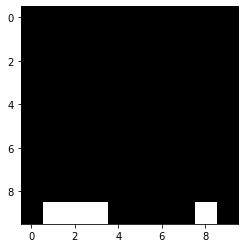

In [5]:
animation = create_animation(model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

## Train and assess model

See how much better it is at dodging the fruit

Episodes 0001-0010/0400 | Loss 0.0059 | Rewards [1, 1, 1, -1, 1, 1, -1, 1, -1, 1]
Episodes 0011-0020/0400 | Loss 0.0592 | Rewards [1, 1, 1, 1, -1, 1, -1, 1, 1, 1]
Episodes 0021-0030/0400 | Loss 0.0349 | Rewards [1, 1, -1, 1, 1, -1, 1, -1, -1, 1]
Episodes 0031-0040/0400 | Loss 0.0513 | Rewards [-1, -1, 1, 1, -1, 1, 1, 1, 1, -1]
Episodes 0041-0050/0400 | Loss 0.0283 | Rewards [1, 1, 1, 1, 1, 1, -1, 1, 1, 1]
Episodes 0051-0060/0400 | Loss 0.0420 | Rewards [-1, 1, -1, 1, 1, 1, 1, 1, -1, 1]
Episodes 0061-0070/0400 | Loss 0.0272 | Rewards [1, 1, 1, 1, 1, 1, 1, -1, 1, 1]
Episodes 0071-0080/0400 | Loss 0.0267 | Rewards [1, 1, -1, 1, 1, 1, 1, 1, 1, 1]
Episodes 0081-0090/0400 | Loss 0.0029 | Rewards [1, 1, 1, -1, 1, 1, 1, -1, 1, 1]
Episodes 0091-0100/0400 | Loss 0.0291 | Rewards [1, 1, 1, 1, -1, -1, 1, 1, 1, 1]
Episodes 0101-0110/0400 | Loss 0.0066 | Rewards [-1, -1, 1, 1, 1, 1, -1, -1, 1, -1]
Episodes 0111-0120/0400 | Loss 0.0339 | Rewards [1, -1, 1, -1, -1, 1, -1, -1, 1, 1]
Episodes 0121-0130/

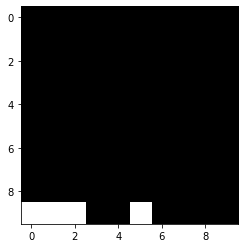

In [6]:
train_model(model, env, exp_replay, num_episodes=400)
animation = create_animation(model, env, num_episodes=10)
IPython.display.HTML(animation.to_jshtml())

# Possible Exercises
1. Standard Difficulty: Add a validation function, to make it easier to assess models.
1. Advanced Difficulty: We've been looking at convolutional neural networks for image processing. Try changing the model to use convolutional layers. Does this seem to work any better?
1. Standard Difficulty: Change the code so that the player is trying to catch the fruit instead of dodging it.
1. Advanced Difficulty: Change the code so the episode keeps going until the player is hit by the fruit. (To test that this is working, you may want to change the number of episodes in the animation to 1.) How should this change the rewards that the model gets?
1. Advanced Difficulty: Change the game to something entirely different.
1. Standard Difficulty: Try changing how the training works (for instance, changing the discount rate or having the model always choose the action randomly weighted by the action values). Keep notes on what you observe as to how this changes the model performance.

In [7]:
# 1. Validation

# Wes and I had a great talk about validation.  My initial way of going about this was looking at the overall trend
# of the model's success percentage (i.e. how does the model improve over the duration of training) which was a good
# idea, but not correct for validation. As the model is training, it is going to have many ups and downs, so evaluating
# it at any place but the end "plateau" is not necessary. Most models plateau at a point (e.g. 85%) and can't get any
# better, hence the word plateau. Thus, for validating this model, which in other words is evaluating how well it 
# did its job which was to play the game better, we can compare the plateau success percentage to the untrained success
# percentage.

# The final few (starting from episode 350) went 10/10, 10/10, 9/10, 10/10, 9/10, averaging 96% success rate (dodge 
# rate).  Our beginning/untrained starting success rate was 6/10 or 60%.  This is a 60% increase in success.
# 60% came from ((96-60)/60)*100.  That says a lot about our model, in that there was a significant improvement in playing'
# which is what we had hoped and intended our program to do, thus, we can say the program/model training was a success!

# 2. Bucket Exploration

# As mentioned above, I talked to Wes about examining the "progression" of the training, by grouping the episodes into
# buckets.  For example, with total 400 episodes, there could be 40 buckets of 10 episodes. This would allow me to 
# examine where the "plateau" starts and ends. Here is a link to my sheet: 

# https://docs.google.com/spreadsheets/d/1M3l8P3Ze0zd9YTrFswcyzb-fFUzRt0noApLe1KxK6us/edit?usp=sharing (shared /w you)

# By the 220th episode, we only see (in the buckets of 10, e.g. 220-230, 230-240 ... ) success rates of 80%+ which is
# not seen before that mark.  I believe this is where the model starts to plateau, and past 330, it is only 100%s and 
# one 90%.  Pretty impressive.

# When I group the buckets by bigger sizes (see sheet, e.g. 80 episodes x 5), you tend to see a general increase. 
# This is a good sign -- for example, 80 episodes x 5 resulted in (starting from 0-80, 80-160, etc.):

# 77.5% --> 65% --> 73.75% --> 88.75% --> 98.75%

# As this shows, the first three intervals or the first 240 or so had some ups and downs which is normal since 
# it is going through the "training" process which won't be smooth.  Nor will it go linearly upwards. It will go up
# overall but there will be a ton of noise and fluctuations, and spaces where it does worse than before (e.g. 77.5%
# to 65%). but this just shows to my earlier point above that you can't evalute the model at these points where it is 
# still in the training process, rather you have to wait until it plateaus or "finishes" the training. then you can 
# evaluate it!

# 3. Training Changes

# Since I spent most of my time examining these buckets and talking about it with my group and Wes, I didn't spend too
# much time on this one. However, I did rerun the entire training process with a different sized board. And the 
# results make a lot of sense and are pretty intuitive. I decreased the board from a 10x10 to a 5x5 which decreased 
# the room for the 3x1 little tile thing to move and thus it failed pretty badly at dodging the fruit when it was 
# placed in the untrained arena.  I think it got something like 10% or 20% -- aka something pretty bad. But, it makes
# total sense -- less room = higher chance that it can't dodge and combined with an untrained model going at almost 
# random leads to a pretty bad run.

# Suprisingly, even with the bad "game scenario" i.e. small board relative to tile size, the training went well.
# I don't have the final data since I wanted to keep the Notebook open with my 10x10 data, but I recall that it was 
# pretty high.  Definitely not in the 95%+ range but well within the 85%-95% range.  This was suprising but I guess this
# is the power of reinforcement learning.  Pretty cool stuff :)

In [8]:
# Exercise 2

# I changed the model (see above) so that it uses a two convolutional layer NN to train the model. I had to do a lot
# of digging and also talked it out with Brandon C. who was very helpful. In addition, I wanted to compare the 
# results of the training of the CNN to the plain feed forward NN and actually saw pretty similar results. My google
# sheet above is the percentage outputs for the feed-forward and upon running 400 episodes with the CNN, they actually
# produce similar percentages.  There are definitely less 100%s and near the end it still fluctuates between 70-100
# whereas the final 100 for the feed forward is 80+ with a lot of 90s and 100s. My thought is that maybe a CNN is too
# advanced for a simple game where it's just catching fruit in a 2d 9x9 grid. Since the CNN also incorperates a feed
# forward NN (when it takes the output flattened) my idea is that the CNN might be over complicating the process.
# those are just thoughts and I'm not too sure in any way, but from the results, it's definitely clear that a) both 
# models do the right thing and are working well, but also b) that the CNN model performs slightly worse than the 
# simple feed forward NN.  Maybe though, 400 episodes isn't enough for the CNN model to plateau. Always more room 
# for exploration!!!!